# Python for Water Resources Engineering
[Jon Herman, University of California, Davis](http://faculty.engineering.ucdavis.edu/herman/)

### Optimization

There are several packages for linear, nonlinear, and quadratic programming in Python. These solvers are typically not written in Python, but provide an interface to a library in a compiled language (C/C++/Fortran).

#### Linear Programming

For linear programming, a few good options are [CVXOPT](http://cvxopt.org/) or [PuLP](https://pythonhosted.org/PuLP/). I'll use `CVXOPT` in these examples because it also provides a quadratic solver. `CVXOPT` should be included with your Anaconda installation, but if not, you can install it from the command line with `pip install cvxopt`.

`CVXOPT` requires costs and constraints in matrix form:

$$\min_{x} \mathbf{c}^T \mathbf{x}$$

$$s.t.: \mathbf{Ax} \leq \mathbf{b}$$

Here is an example problem from the [CVXOPT documentation](http://cvxopt.org/examples/tutorial/lp.html):

$$\min_{x} 2x_1 + x_2$$

$$s.t.: -x_1 + x_2 \leq 1$$

$$x_1 + x_2 \geq 2$$

$$x_2 \geq 0$$

$$x_1 - 2x_2 \leq 4$$

After rearranging the constraints to be "less-than", the problem can be solved like this:

In [1]:
import cvxopt as cvx
A = cvx.matrix([ [-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0] ])
b = cvx.matrix([ 1.0, -2.0, 0.0, 4.0 ])
c = cvx.matrix([ 2.0, 1.0 ])
sol = cvx.solvers.lp(c,A,b)

     pcost       dcost       gap    pres   dres   k/t
 0:  2.6471e+00 -7.0588e-01  2e+01  8e-01  2e+00  1e+00
 1:  3.0726e+00  2.8437e+00  1e+00  1e-01  2e-01  3e-01
 2:  2.4891e+00  2.4808e+00  1e-01  1e-02  2e-02  5e-02
 3:  2.4999e+00  2.4998e+00  1e-03  1e-04  2e-04  5e-04
 4:  2.5000e+00  2.5000e+00  1e-05  1e-06  2e-06  5e-06
 5:  2.5000e+00  2.5000e+00  1e-07  1e-08  2e-08  5e-08
Optimal solution found.


Note that `CVXOPT` has a different matrix object type than NumPy. They are compatible, but if you have a NumPy matrix `M`, you must give `matrix(M)` to the solver. You may need to do this for example if you read a large matrix of constraints in from a file using NumPy.

The solution `sol` is a `dict` with the following keys:

In [2]:
print sol.keys()

['status', 'dual slack', 'iterations', 'residual as primal infeasibility certificate', 'relative gap', 'dual objective', 'residual as dual infeasibility certificate', 'gap', 's', 'primal infeasibility', 'dual infeasibility', 'primal objective', 'primal slack', 'y', 'x', 'z']


The optimal decision variables are contained in `sol['x']`. The optimal objective value is contained in `sol['primal objective']`. The values of the slack variables are contained in `sol['s']`, and the dual variables are given by `sol['z']`. Note that values with `e-08` can be treated as zero here.

In [3]:
print(sol['x'])
print(sol['primal objective'])

[ 5.00e-01]
[ 1.50e+00]

2.49999998955


To see how we did, we can create a contour plot using Matplotlib:

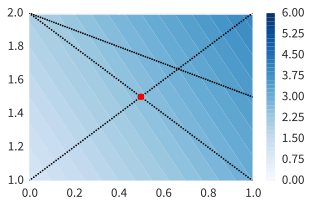

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipy_setup import setup
setup(plt)
X1,X2 = np.meshgrid(np.arange(0,2,0.01), np.arange(0,2,0.01))
Z = 2*X1 + X2

# Contour lines in the background
plt.contourf(X1,X2,Z,50,cmap=plt.cm.Blues)
plt.colorbar()

# Plot constraint lines
plt.plot(X1,1+X1, color='k')
plt.plot(X1,2-X1, color='k')
plt.plot(X1,(4-X1)/float(2), color='k')

# And the optimal point ...
plt.scatter(sol['x'][0], sol['x'][1], s=40, color='r', zorder=5)
plt.xlim([0,1])
plt.ylim([1,2])
plt.show()


#### Quadratic Programming

We can also solve quadratic programs with `CVXOPT`. Again, the costs and constraints are expected to be in matrix form:

$$\min_{x} \frac{1}{2}\mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T\mathbf{x}$$

$$s.t.: \mathbf{Gx} \leq \mathbf{h}$$

$$\mathbf{Ax} = \mathbf{b}$$

If we take the [CVXOPT example](http://cvxopt.org/examples/tutorial/qp.html) for quadratic programming, we can define matrices for the coefficients and solve the problem in the same way as the linear program above:

$$\min_{x} 2x_1^2 + x_2^2 + x_1x_2 + x_1 + x_2$$

$$s.t.: x_1 \geq 0$$

$$x_2 \geq 0$$

$$x_1 + x_2 = 1$$


In [5]:
import cvxopt as cvx
Q = 2*cvx.matrix([ [2, .5], [.5, 1] ])
p = cvx.matrix([1.0, 1.0])
G = cvx.matrix([[-1.0,0.0],[0.0,-1.0]])
h = cvx.matrix([0.0,0.0])
A = cvx.matrix([1.0, 1.0], (1,2)) # dimensions needed for row matrix
b = cvx.matrix(1.0)
sol = cvx.solvers.qp(Q, p, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  3e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  2e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  1e-16  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  1e-16  5e-08
Optimal solution found.


In [6]:
print(sol['x'])
print(sol['primal objective'])

[ 2.50e-01]
[ 7.50e-01]

1.875


Let's again make a contour plot and confirm that the result makes sense:

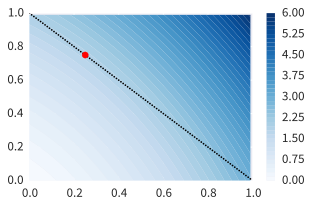

In [7]:
X1,X2 = np.meshgrid(np.arange(0,1,0.01), np.arange(0,1,0.01))
Z = 2*X1**2 + X2**2 + X1*X2 + X1 + X2

# Contour lines in the background
plt.contourf(X1,X2,Z,50,cmap=plt.cm.Blues)
plt.colorbar()

# Plot constraint lines
plt.plot(X1,1-X1, color='k')

# And the optimal point ...
plt.scatter(sol['x'][0], sol['x'][1], s=40, color='r', zorder=5)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

#### Nonlinear Programming - Constrained and Unconstrained
Finally, for general non-linear programming (gradient-based search for local optima), refer to `scipy.optimize`. SciPy is another package that you can expect to be included in most research analyses. [Here is an example](https://scipy-lectures.github.io/intro/scipy.html#optimization-and-fit-scipy-optimize) of defining a general smooth function `f(x)` and performing a gradient-based optimization starting from a given point.

Let's try this for the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), which has a global minima at $f(1,1)=0$:

In [26]:
def rosenbrock(x):
    return (1-x[0])**2 + 100*(x[1] - x[0]**2)**2

from scipy import optimize
sol = optimize.minimize(rosenbrock, [0,3]) # (0,3) is the starting location
print sol.keys()

['status', 'success', 'njev', 'nfev', 'hess_inv', 'fun', 'x', 'message', 'jac', 'nit']


Since this method is part of `SciPy`, not `CVXOPT`, there is a slightly different format for the output. `sol['x']` contains the decision variables and `sol['fun']` contains the optimal function value. **This will only find local minima**, not global, so the choice of starting location is important. 

Here we did not provide a function for the gradient; it's being estimated numerically during the search. If the gradient function is known, it can be passed into the function using the `jac` keyword (Jacobian). [Scipy.minimize](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) is an interface to many different methods, and the documentation describes lots of options that are not covered here.

In [27]:
print(sol['x'])
print(sol['fun'])

[ 0.99999569  0.99999136]
1.8624964287e-11


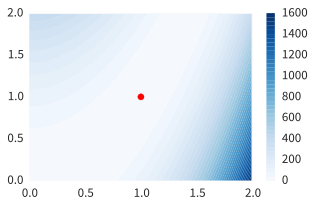

In [32]:
X1,X2 = np.meshgrid(np.arange(0,2,0.01), np.arange(0,2,0.01))
Z = (1-X1)**2 + 100*(X2 - X1**2)**2

# Contour lines in the background
plt.contourf(X1,X2,Z,50,cmap=plt.cm.Blues)
plt.colorbar()

# And the optimal point ...
plt.scatter(sol['x'][0], sol['x'][1], s=40, color='r', zorder=5)
plt.xlim([0,2])
plt.ylim([0,2])
plt.show()

Finally, we can do the same thing with constraints. If you only have box constraints on the decision variables, you can specify `bounds` as a list of `(min,max)` pairs:

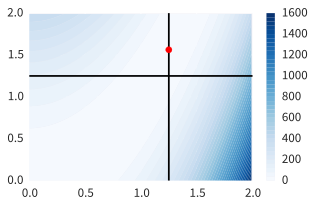

In [34]:
bounds = [(1.25, None), (1.25, 2)]
sol = optimize.minimize(rosenbrock, [0,3], bounds=bounds)
plt.contourf(X1,X2,Z,50,cmap=plt.cm.Blues)
plt.colorbar()
plt.plot([1.25,1.25],[0,2], color='k')
plt.plot([0,2],[1.25,1.25], color='k')
plt.scatter(sol['x'][0], sol['x'][1], s=40, color='r', zorder=5)
plt.xlim([0,2])
plt.ylim([0,2])
plt.show()

In the more complicated case that the constraint is a function of one or more decision variables, define the function and use the `constraints` keyword with a dictionary describing your constraint. For example, we'll enforce $x_1 + 2x_2 \leq 2$:

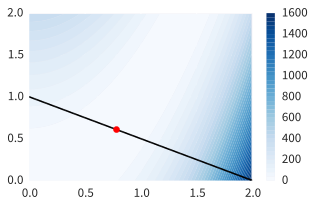

In [43]:
# if return value > 0, constraint satisfied
# if < 0, constraint violated
def f_constraint(x):
    return -(x[0] + 2*x[1] - 2)

constraint = {'type': 'ineq', 'fun': f_constraint}
sol = optimize.minimize(rosenbrock, [0,3], constraints=constraint)
plt.contourf(X1,X2,Z,50,cmap=plt.cm.Blues)
plt.colorbar()
plt.plot(X1,(2-X1)/2, color='k')
plt.scatter(sol['x'][0], sol['x'][1], s=40, color='r', zorder=5)
plt.xlim([0,2])
plt.ylim([0,2])
plt.show()